## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from time import time
import os
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import itertools
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train = True, 
                                                        transform = train_transform,
                                                        target_transform = None,
                                                        download = download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train = False, 
                                                       transform = test_transform,
                                                       target_transform = None,
                                                       download = download)
def test_train_split(dataset, split = 0.8):    
    """
    Looks similar to sklearn one.
    Params:
    --------------
    dataset -- torch.utils.data.Dataset to split
    split -- float, split (to train size)
    Returns:
    --------------
    train_set, valid_set -- splitted Datasets of size:
    (split * len(dataset), len(dataset) - len(train_set))
    """
    train_size = int(split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

train_set, valid_set = test_train_split(fmnist_dataset_train, .75)

In [4]:
train_loader = DataLoader(train_set, batch_size = 128,
                                           shuffle = True,
                                           num_workers = 2)
valid_loader = DataLoader(valid_set, batch_size = 128,
                                           shuffle = False,
                                           num_workers = 2)

test_loader = DataLoader(fmnist_dataset_test, batch_size = 256,
                                          shuffle = False,
                                          num_workers = 2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.Dropout(0.25),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(0.33),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes), )
        
    def forward(self, x):       
        return self.model(x)
    

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
           Dropout-3                  [-1, 128]               0
       BatchNorm1d-4                  [-1, 128]             256
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,256
           Dropout-7                   [-1, 64]               0
       BatchNorm1d-8                   [-1, 64]             128
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated T

Your experiments come here:

In [9]:
# model = TinyNeuralNetwork().to(device)
# opt = torch.optim.Adam(model.parameters(), lr = 1e-3)# YOUR CODE HERE
# loss_func = nn.CrossEntropyLoss()# YOUR CODE HERE

def train_model(model, train_loader, valid_loader, loss_fn, opt, n_epochs: int, device = device):
    
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1] 
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

def evaluate_model(model, test_loader, loss_fn, opt):
    _ = model.eval()
    print("\n\n TESTING MODEL...")
    losses = []
    metrics = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            
            y_pred = predictions.max(1)[1]
            losses.append(loss.item())
            metrics.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu() \
                            .numpy().astype(float))/ len(y_batch.cpu()))
            
    print(f"\t test loss: {np.mean(losses):.6f}")
    print(f"\t test accuracy: {np.mean(metrics):.3f}")
    return losses, metrics
# Your experiments, training and validation loops here
# train_loss, val_loss, val_accuracy = train_model(model, train_loader, valid_loader,
#                                                 loss_func, opt, 10)
# _ = evaluate_model(model, test_loader, loss_func, opt)
# plt.plot(train_loss, color = 'r', label = 'train loss')
# plt.plot(val_loss, label = 'validation loss')
# plt.legend(loc = 'best')


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [21]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape = 28 * 28, num_classes = 10, input_channels = 1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 64),
            nn.Dropout(0.88),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):       
        return self.model(x)

In [22]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 64]          50,240
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 10]             650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


Epoch 1 of 15 took 3.369s
	  training loss: 1.690540
	validation loss: 1.136641
	validation accuracy: 0.665
Epoch 2 of 15 took 3.479s
	  training loss: 1.239644
	validation loss: 0.898055
	validation accuracy: 0.696
Epoch 3 of 15 took 3.555s
	  training loss: 1.089546
	validation loss: 0.801751
	validation accuracy: 0.718
Epoch 4 of 15 took 3.660s
	  training loss: 1.021253
	validation loss: 0.746166
	validation accuracy: 0.744
Epoch 5 of 15 took 3.591s
	  training loss: 0.967458
	validation loss: 0.708625
	validation accuracy: 0.761
Epoch 6 of 15 took 3.744s
	  training loss: 0.934142
	validation loss: 0.678719
	validation accuracy: 0.767
Epoch 7 of 15 took 3.754s
	  training loss: 0.909405
	validation loss: 0.654759
	validation accuracy: 0.778
Epoch 8 of 15 took 3.906s
	  training loss: 0.893728
	validation loss: 0.635303
	validation accuracy: 0.790
Epoch 9 of 15 took 4.006s
	  training loss: 0.872068
	validation loss: 0.617939
	validation accuracy: 0.798
Epoch 10 of 15 took 3.996s
	

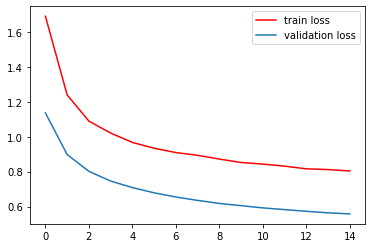

In [23]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 1e-2)# YOUR CODE HERE
loss_func = nn.CrossEntropyLoss()
train_loss, val_loss, val_accuracy = train_model(model, train_loader, 
                                                 valid_loader,
                                                loss_func, opt, 15)
_ = evaluate_model(model, test_loader, loss_func, opt)
plt.plot(train_loss, color = 'r', label = 'train loss')
plt.plot(val_loss, label = 'validation loss')
plt.legend(loc = 'best')
# Your experiments, come here

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [24]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [14]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [15]:
model = FixedNeuralNetwork().to(device)
opt = # YOUR CODE HERE
loss_func = # YOUR CODE HERE

# Your experiments, come here

SyntaxError: invalid syntax (<ipython-input-15-20526558a449>, line 2)

### Conclusions:
_Write down small report with your conclusions and your ideas._